# The Assemble Module

The `assemble` module of the `ah` package finds and forms the essential structure components. These 
components are the smallest building blocks that form the basis for every repeat in the song. The functions in this module ensure each time step of a song is contained in at most one of the song's essential  structure component by making none of the repeats overlap in time. When repeats do overlap, these repeats undergo a process 
where they are divided until there are only non-overlapping pieces left over.

- **breakup_overlaps_by_intersect**: Extracts repeats in *input\_pattern\_obj* that has the starting indices of the repeats, into the essential structure componets using *bw\_vec*, that has the lengths of each repeat.
    
- **check_overlaps**: Compares every pair of groups, determining if there are any repeats in any pairs of the groups that overlap. 
    
- **\_\_compare_and_cut**: Compares two rows of repeats labeled RED and BLUE, and determines if there are any overlaps in time between them. If there is, then we cut the repeats in RED and BLUE into up to 3 pieces. 

- **\_\_num_of_parts**: Determines the number of blocks of consecutive time steps in a list of time steps. A block of consecutive time steps represents a distilled section of a repeat.

- **\_\_inds_to_rows**:  Expands a vector containing the starting indices of a piece or two of a repeat into a matrix representation recording when these pieces occur in the song with 1's. All remaining entries are marked with 0's.

- **\_\_merge_based_on_length**: Merges repeats that are the same length, as set by *full\_bandwidth*, and are repeats of the same piece of structure.

- **\_\_merge_rows**: Merges rows that have at least one common repeat; said common repeat(s) must occur at the same time step and be of common length.

- **hierarchical_structure**: Distills the repeats encoded in *matrix\_no\_overlaps* (and *key\_no\_overlaps*) to the essential structure components and then builds the hierarchical representation.

- **hierarchical_structure_with_vis**: Same as hierarchical_structure but this also outputs visualizations of the hierarchical representations.

- **hierarchical\_structure\_test**: Distills the repeats encoded in *matrix\_no\_overlaps* (and *key\_no\_overlaps*) to the essential structure components and then builds the hierarchical representation. Also optionally outputs visualizations of the hierarchical representations.

This module uses `find_all_repeats` from the [`search`](../ah/blob/master/vignettes/search_vignette.ipynb) module and `reconstruct_full_block` from the [`utilities`](../ah/blob/master/vignettes/utilities_vignette.ipynb) module. 

For more in depth information on the function calls, an example function pipeline is shown below. Functions from the current module are shown in purple.

<img src="pictures/assemble_color_sample.png" alt="Chart" style="width:150px;" align = "left"/>]
<img src="pictures/assemble_pipeline.png" alt="Chart" style="width:340px;" align = "middle"/>


## Import Modules

In [16]:
# numpy is used for mathematical calculations
import numpy as np

# Set the path for the import
import sys
import os
sys.path.append(os.path.join(os.path.dirname('__file__'), '../aligned-hierarchies'))

# Import other modules
from inspect import signature 
from assemble import *
from assemble import __num_of_parts, __inds_to_rows, __compare_and_cut, __merge_based_on_length, __merge_rows
from search import find_all_repeats
from utilities import reconstruct_full_block

## breakup_overlaps_by_intersect 

The purpose of this function is to create the essential structure components matrix. The essential structure components contain the smallest building blocks that form every repeat in the song. This matrix is created using the *input\_pattern\_object*, that has the starting indices of the repeats and a vector, *bw\_vec*, that has the lengths of each repeats. 
 
The inputs for this function are: 
- **input_pattern_obj** (np.ndarray): A binary matrix with 1's where repeats begin and 0's otherwise
-  **bw_vec** (np.ndarray): Lengths of the repeats encoded in *input\_pattern\_obj*
- **thresh_bw** (int): The smallest allowable repeat length 

The outputs for this function are: 
- **pattern_no_overlaps** (np.ndarray): A binary matrix with 1's where repeats of essential structure components begin 
- **pattern_no_overlaps_key** (np.ndarray): A vector containing the lengths of the repeats of essential structure components in *pattern\_no\_overlaps* 

In [24]:
input_pattern_obj = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                              [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
bw_vec = np.array([[3],
                   [5],
                   [8],
                   [8]])
thresh_bw = 0
print("The input array is: \n", input_pattern_obj)
print("The lengths of the repeats in the input array is: \n", bw_vec)
print("The smallest allowable repeat length is: ", thresh_bw)

The input array is: 
 [[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
The lengths of the repeats in the input array is: 
 [[3]
 [5]
 [8]
 [8]]
The smallest allowable repeat length is:  0


In [25]:
output = breakup_overlaps_by_intersect(input_pattern_obj, bw_vec, thresh_bw)

print("The output array is: \n", output[0])
print("The lengths of the repeats in the output array is: \n", output[1])

The output array is: 
 [[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
The lengths of the repeats in the output array is: 
 [[3]
 [5]]


## check_overlaps

This function compares every pair of groups and checks for overlaps between those pairs. To check every pair of groups, the function creates *compare\_left* and *compare\_right*. *compare\_left* repeats each row the number of rows times, and _compare\_right_ repeats the whole input the number of rows times times. By comparing each corresponding time step in *compare\_left* and *compare\_right*, it determines if there are any overlaps between groups.

The input for this function is: 

- **input_mat** (np.ndarray): An array waiting to be checked for overlaps

The output for this function is: 
- **overlaps\_yn** (np.ndarray): A logical array where (i,j) = 1 if row i of input matrix and row j of input matrix overlap and (i,j) = 0 elsewhere

In [26]:
input_mat = np.array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                      [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]])

print("The input array waiting to be checked for overlaps is: \n", input_mat)

The input array waiting to be checked for overlaps is: 
 [[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0]
 [1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1]]


In [27]:
output = check_overlaps(input_mat)

print("The output logical array is: \n", output)

The output logical array is: 
 [[False  True  True  True]
 [False False  True  True]
 [False False False False]
 [False False False False]]


## \_\_num_of_parts

This function is used to determine the number of blocks of consecutive timesteps in a list of timesteps. A block of consecutive timesteps
represent a distilled section of a repeat. This distilled section will be replicated and the starting indices of the repeats within it will be 
returned. At the beginning of this function, it uses variable breakmark to check if *input\_vec* contains a whole group of consecutive timesteps or two groups of consecutive timesteps. Then these two conditions go into the if-else statement separately and returns the moved starting indices and the corresponding lengths.

<img src="pictures/num_of_parts.png" alt="Chart" style="width:800px;" align = "middle"/>

As the above pictures shows, red and blue are two repeats, and purple is their intersection. Now we want to know the starting indices and length of the remaining part after cutting purple out of all of the repeats in red. Case a and b will enter the if-statement (see example 1) and c will enter else-statement (see example 2) because we can see how many parts in *input\_vec* in the picture clearly.

The inputs for this function are: 

- **input_vec** (np.ndarray): One or two parts of a repeat that are overlaps in time that may need to be replicated            
- **input_start** (np.ndarray): The starting indicies for the section to be replicated 
- **input_all_starts** (np.ndarray): The starting indices for replication 

The outputs for this function are: 
- **start_mat** (np.ndarray): The starting indices of the replicated repeats          
- **length_vec** (np.ndarray): Lengths of the replicated parts

**Example 1** enters the if-statement: 

In [28]:
input_vec = np.array([3, 4])
input_start = np.array([0])
input_all_starts = np.array([3, 7, 10])

print("The input array is: \n", input_vec)
print("The starting indices for the part to be replicated is: \n", input_start)
print("The starting indices for replication is: \n", input_all_starts)

The input array is: 
 [3 4]
The starting indices for the part to be replicated is: 
 [0]
The starting indices for replication is: 
 [ 3  7 10]


In [29]:
output = __num_of_parts(input_vec, input_start, input_all_starts)

print("The starting indices of the replicated repeats is: \n", output[0])
print("The lengths of the replicated parts is: ", output[1])

The starting indices of the replicated repeats is: 
 [ 6 10 13]
The lengths of the replicated parts is:  2


**Example 2** enters the else-statement: 

In [30]:
input_vec = np.array([3, 5])
input_start = np.array([3])
input_all_starts = np.array([3, 7, 10])

print("The input array is: \n", input_vec)
print("The starting indices for the part to be replicated is: \n", input_start)
print("The starting indices for replication is: \n", input_all_starts)

The input array is: 
 [3 5]
The starting indices for the part to be replicated is: 
 [3]
The starting indices for replication is: 
 [ 3  7 10]


In [49]:
output = __num_of_parts(input_vec, input_start, input_all_starts)
print("The starting indices of the replicated repeats is: \n", output[0])
print("The lengths of the replicated parts is: \n", output[1])

The starting indices of the replicated repeats is: 
 [[ 3  7 10]
 [ 5  9 12]]
The lengths of the replicated parts is: 
 [[1]
 [1]]


## \_\_inds_to_rows

This function expands a vector containing the starting indices of a piece or two of a repeat into a matrix representation recording when these pieces occur in the song with 1's. All remaining entries are marked with 0's.

The inputs for this function are: 

- **start_mat** (np.ndarray): A matrix of one or two rows, containing the starting indices            
- **row_length** (int): Length of the rows

The output for this function is: 

- **new_mat** (np.ndarray): A matrix of one or two rows, with 1's where the starting indices are and 0's otherwise 

In [31]:
start_mat = np.array([0, 1, 6, 7])
row_length = 10

print("The array containing the starting indices is: \n",start_mat)
print("The length of the rows is: ", row_length)

The array containing the starting indices is: 
 [0 1 6 7]
The length of the rows is:  10


In [32]:
output = __inds_to_rows(start_mat, row_length)

print("The output array is: \n", output)

The output array is: 
 [[1 1 0 0 0 0 1 1 0 0]]


## compare_and_cut

This function compares two rows of repeats labeled RED and BLUE, and determines if there are any overlaps in time between them, calling these repeats PURPLE. 

<img src="pictures/Red1Blue1Purple1.png" alt="Chart" style="width:800px;" align = "middle"/>

If there are overlaps between RED and BLUE, then it cuts the repeats in RED and BLUE into 3 pieces. This function first determines if there is any intersection between the rows. If there is, it then starts comparing one repeat in RED to one repeat in BLUE. 

With the intersection of the two repeats, PURPLE, `__num_of_parts_` determines the starting indices and lengths of the overlap section. Then using these new starting indices and lengths a binary matrix is created with 1's where repeats start and 0's otherwise. After we have the new matrices, we call `merge_based_on_length` to merge repeats that are the same length.

<img src="pictures/Red2Blue2Purple2.png" alt="Chart" style="width:800px;" align = "middle"/>


If the merged results have repeats within a row, we will call `compare_and_cut` again on the row with overlapping repeats. In this case, PURPLE still have overlaps. When `compare_and_cut` is called on PURPLE, the output is:


<img src="pictures/Red3Blue3Purple3.png" alt="Chart" style="width:800px;" align = "middle"/>

After `merge_based_on_length` is called on these three rows, the output is:

<img src="pictures/Purple4.png" alt="Chart" style="width:800px;" align = "middle"/>

Now, this merged row is appended to the original cut RED and BLUE, and the PURPLE that had been cut is deleted. This finally outputs:

<img src="pictures/Red2Blue2Purple4.png" alt="Chart" style="width:800px;" align = "middle"/>

The inputs for this function are: 

- **red** (np.ndarray): A binary row vector encoding a set of repeats with 1's where each repeat starts and 0's otherwise 
- **red_len** (np.ndarray): Length of repeats encoded in *red*
- **blue** (np.ndarray): A binary row vector encoding a set of repeats with 1's where each repeat starts and 0's otherwise
- **blue_len** (np.ndarray): Length of repeats encoded in *blue*

The outputs for this function are: 

- **union_mat** (np.ndarray): A binary matrix representation of up to three rows encoding non-overlapping repeats cut from *red* and *blue*
- **union_length** (np.ndarray): A vector containing the lengths of the repeats encoded in _union\_mat_

In [33]:
red = np.array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
red_len = np.array([5])
blue = np.array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
blue_len = np.array([3])

print("The first set of repeat is: \n", red)
print("The length of the first set of repeat is: \n", red_len)
print("The second set of repeat is: \n", blue)
print("The length of the second set of repeat is: \n", blue_len)

The first set of repeat is: 
 [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
The length of the first set of repeat is: 
 [5]
The second set of repeat is: 
 [1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0]
The length of the second set of repeat is: 
 [3]


In [34]:
output = __compare_and_cut(red, red_len, blue, blue_len)

print("The output array containing the non-overlapping repeats are: \n", output[0])
print("The array containing the lengths of repeats are: \n", output[1])

The output array containing the non-overlapping repeats are: 
 [[1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0]
 [1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
The array containing the lengths of repeats are: 
 [[1]
 [1]
 [2]]


##  \_\_merge_based_on_length

This function merges repeats that are the same length, as set by *full\_bw*, and are repeats of the same piece of structure. In the merging process, if there are rows that have at least one common repeat, the function will call `_merge_rows` to actually merge them.

The inputs of this function are: 

- **full_mat** (np.ndarray): A binary matrix with 1's where repeats start and 0's otherwise
- **full_bw** (np.ndarray): The length of repeats encoded in *input\_mat*
- **target_bw** (np.ndarray): The length of repeats that we seek to merge

The outputs of this function are: 

- **out_mat** (np.ndarray): A binary matrix with 1's where repeats start and 0's otherwise with rows of *full\_mat* merged if appropriate
- **one_length_vec** (np.ndarray): The length of the repeats encoded in *out\_mat*

In [35]:
full_mat = np.array([[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                     [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]])
full_bw = np.array([[2],
                    [2]])
target_bw = np.array([[2],
                      [2]])
print("The input array is: \n", full_mat)
print("The length of repeats in input array is: \n", full_bw)
print("The length of repeats we seek to merge is: \n", target_bw)

The input array is: 
 [[0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0]]
The length of repeats in input array is: 
 [[2]
 [2]]
The length of repeats we seek to merge is: 
 [[2]
 [2]]


In [36]:
output = __merge_based_on_length(full_mat, full_bw, target_bw)

print("The merged array is: \n", output[0])
print("The length of repeats in the output array is: \n", output[1])

The merged array is: 
 [[1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0]]
The length of repeats in the output array is: 
 [2]


##  \_\_merge_rows

This function merges rows that have at least one common repeat; said common repeat(s) must occur at the same timestep and be of common length. In a while loop, the function checks all the unchecked rows one-by-one, finds indices of the unmerged overlapping rows, unite rows with starting indices in common, and checks that newly merged rows do not cause overlaps within row. If there are conflicts, `compare_and_cut` is called. When there are no unchecked rows, it quits the function and finally returns the merged matrix.

The inputs for this function are: 

- **input_mat** (np.ndarray): A binary matrix with 1's where repeats start and 0's otherwise
- **input_width** (np.ndarray): The length of repeats encoded in _input\_mat_

The output for this function is: 

- **merge_mat** (np.ndarray): A binary matrix with 1's where repeats start and 0's otherwise

In [37]:
input_mat = np.array([[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
                      [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]])
input_width = np.array([1])

print("The input array is: \n", input_mat)
print("The length of repeats in the input array is: \n", input_width)

The input array is: 
 [[0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0]
 [1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0]]
The length of repeats in the input array is: 
 [1]


In [38]:
output = __merge_rows(input_mat, input_width)

print("The merged array is: \n", output)

The merged array is: 
 [[1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0]]


##  hierarchical\_structure

This function distills the repeats encoded in matrix\_no\_overlaps (and key\_no\_overlaps), which are the outputs from the remove\_overlaps function from the transform module, to the essential structure components and then builds the hierarchical representation

The inputs for this function are: 

- **matrix\_no\_overlaps** (np.array\[int]): A binary matrix with 1's where repeats begin and 0's otherwise
- **key\_no\_overlaps** (np.array\[int]): A vector containing the lengths of the repeats encoded in matrix_NO
- **sn** (int): The song length, which is the number of audio shingles
    
The output for this function is: 

- **full_visualization** (np.array\[int]): A binary matrix representation for full_matrix_NO with blocks of 1's equal to the length's prescribed in full_key
            
- **full_key** (np.array\[int]): A vector containing the lengths of the hierarchical structure encoded in full_matrix_NO
            
- **full_matrix_NO** (np.array\[int]): A binary matrix with 1's where hierarchical structure begins and 0's otherwise
            
- **full_anno_lst** (np.array\[int]): A vector containing the annotation markers of the hierarchical structure encoded in each row of full_matrix_NO

In [17]:
matrix_no_overlaps = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
key_no_overlaps = np.array([2])
sn = 20

print("The matrix representation of the non-overlapping repeats is: \n", matrix_no_overlaps)
print("The lengths of the repeats in matrix_no_overlaps are: \n", key_no_overlaps)
print("The song length is: \n", sn)


The matrix representation of the non-overlapping repeats is: 
 [[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
The lengths of the repeats in matrix_no_overlaps are: 
 [2]
The song length is: 
 20


In [18]:
output = hierarchical_structure(matrix_no_overlaps, key_no_overlaps, sn)

full_visualization = output[0]
full_key = output[1]
full_matrix_no = output[2]
full_anno_lst = output[3]

print("The binary matrix representation for the full_matrix_no is: \n", full_visualization)
print("The vector containing the lengths of the hierarchical structure encoded in full_matrix_no is: \n", full_key)
print("The binary matrix with 1's where hierarchical structure begins and 0's otherwise is: \n", full_matrix_no)
print("The vector containing the annotation markers of the hierarchical structure encoded in each row of full_matrix_no is: \n", full_anno_lst)

The binary matrix representation for the full_matrix_no is: 
 [[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]
The vector containing the lengths of the hierarchical structure encoded in full_matrix_no is: 
 [[2.]]
The binary matrix with 1's where hierarchical structure begins and 0's otherwise is: 
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
The vector containing the annotation markers of the hierarchical structure encoded in each row of full_matrix_no is: 
 [1]


##  hierarchical\_structure\_with\_vis

This function is the same as `hierarchical_structure` above, but additionally shows visualizations of the hierarchical representations.

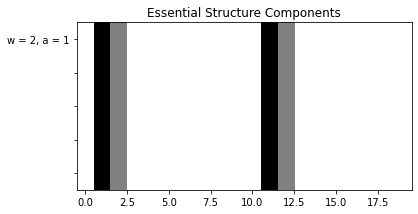

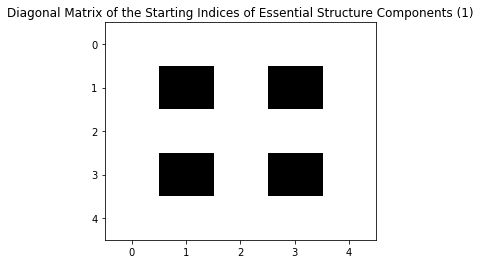

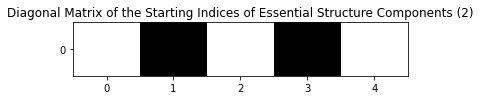

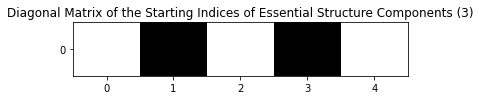

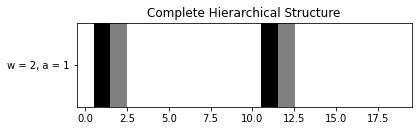

In [19]:
# inputs are taken from above
output = hierarchical_structure_with_vis(matrix_no_overlaps, key_no_overlaps, sn)


##  hierarchical\_structure\_test

This function distills the repeats encoded in matrix\_no\_overlaps (and key\_no\_overlaps), which are the outputs from the remove\_overlaps function from the transform module, to the essential structure components and then builds the hierarchical representation. It optionally shows visualizations of the hierarchical structure via the `vis` argument.

The inputs for this function are: 

- **matrix\_no\_overlaps** (np.array\[int]): A binary matrix with 1's where repeats begin and 0's otherwise
- **key\_no\_overlaps** (np.array\[int]): A vector containing the lengths of the repeats encoded in matrix_NO
- **sn** (int): The song length, which is the number of audio shingles
- **vis** (bool): shows visualizations if True (default = False)
    
The output for this function is: 

- **full_visualization** (np.array\[int]): A binary matrix representation for full_matrix_NO with blocks of 1's equal to the length's prescribed in full_key
            
- **full_key** (np.array\[int]): A vector containing the lengths of the hierarchical structure encoded in full_matrix_NO
            
- **full_matrix_NO** (np.array\[int]): A binary matrix with 1's where hierarchical structure begins and 0's otherwise
            
- **full_anno_lst** (np.array\[int]): A vector containing the annotation markers of the hierarchical structure encoded in each row of full_matrix_NO

In [20]:
matrix_no_overlaps = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
key_no_overlaps = np.array([2])
sn = 20

print("The matrix representation of the non-overlapping repeats is: \n", matrix_no_overlaps)
print("The lengths of the repeats in matrix_no_overlaps are: \n", key_no_overlaps)
print("The song length is: \n", sn)


The matrix representation of the non-overlapping repeats is: 
 [[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
The lengths of the repeats in matrix_no_overlaps are: 
 [2]
The song length is: 
 20


In [22]:
output = hierarchical_structure_test(matrix_no_overlaps, key_no_overlaps, sn, vis=True)

full_visualization = output[0]
full_key = output[1]
full_matrix_no = output[2]
full_anno_lst = output[3]

print("The binary matrix representation for the full_matrix_no is: \n", full_visualization)
print("The vector containing the lengths of the hierarchical structure encoded in full_matrix_no is: \n", full_key)
print("The binary matrix with 1's where hierarchical structure begins and 0's otherwise is: \n", full_matrix_no)
print("The vector containing the annotation markers of the hierarchical structure encoded in each row of full_matrix_no is: \n", full_anno_lst)